In [36]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten, Concatenate, Dropout, Reshape, BatchNormalization
from tensorflow.keras.models import Model


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3331245772380035522
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23404396749
locality {
  bus_id: 1
  links {
  }
}
incarnation: 658278615729598277
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
workdir = "path" # please set the path where the dataset located in

# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]
# IC50evaluation//Dataset//MDG160K
dataset = np.load(workdir + "//190320_cls4_druginfo_change.npz") # MDG160K input file
ss0 = np.load(workdir + '//190315_shuffle_split_r0.npz') # split for training set and test set

In [4]:
x = dataset['x']
y = dataset['y_lnIC50']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [5]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [6]:
# In[15]:
ab =[]
for i in range(100,200):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

2 24


In [7]:
x.shape

(160375, 23538)

In [8]:
training_image_array.shape

(144338, 23538)

In [10]:
# In[21]: Hyper parameter section

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [20]:
train_X[:,21213:].shape

(144338, 2325)

In [21]:
train_X_cell = train_X[:,:21213]
train_X_drug =train_X[:,21213:]
test_X_cell = test_X[:,:21213]
test_X_drug = test_X[:,21213:]

In [22]:
train_X_cell.shape

(144338, 21213)

In [24]:
train_X_cell = train_X_cell.reshape(train_X_cell.shape[0], train_X_cell.shape[1], 1)
train_X_drug = train_X_drug.reshape(train_X_drug.shape[0], train_X_drug.shape[1], 1)
test_X_cell = test_X_cell.reshape(test_X_cell.shape[0], test_X_cell.shape[1], 1)
test_X_drug = test_X_drug.reshape(test_X_drug.shape[0], test_X_drug.shape[1], 1)
#input_shape = (img_rows, img_cols, 1)

In [25]:
print(train_X_cell.shape,train_X_drug.shape, train_y.shape, test_X_cell.shape,test_X_drug.shape, test_y.shape)

(144338, 21213, 1) (144338, 2325, 1) (144338,) (16037, 21213, 1) (16037, 2325, 1) (16037,)


In [13]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (144338, 23538, 1)
144338 train samples
16037 test samples


In [39]:
# Model architecture

with K.tf.device('/GPU:0'):
    input_cell = Input(shape=(train_X_cell.shape[1], train_X_cell.shape[2]), name='cell_input')
    input_drug = Input(shape=(train_X_drug.shape[1], train_X_drug.shape[2]), name='drug_input')

    conv_cell_line_1 = Conv1D(filters=50, kernel_size=700, strides=5, activation='tanh')(input_cell)
    maxpool_cell_line_1 = MaxPooling1D(pool_size=5)(conv_cell_line_1)
    conv_cell_line_2 = Conv1D(filters=30, kernel_size=5, strides=2, activation='relu')(maxpool_cell_line_1)
    maxpool_cell_line_2 = MaxPooling1D(pool_size=10)(conv_cell_line_2)
    flatten_cell_line = Flatten()(maxpool_cell_line_2)
    dense_cell_line = Dense(100, activation='relu')(flatten_cell_line)
    dropout_cell_line = Dropout(0.1)(dense_cell_line)

    conv_drug_1 = Conv1D(filters=50, kernel_size=200, strides=3, activation='tanh')(input_drug)
    maxpool_drug_1 = MaxPooling1D(pool_size=5)(conv_drug_1)
    conv_drug_2 = Conv1D(filters=30, kernel_size=50, strides=5, activation='relu')(maxpool_drug_1)
    maxpool_drug_2 = MaxPooling1D(pool_size=10)(conv_drug_2)
    flatten_drug = Flatten()(maxpool_drug_2)
    dense_drug = Dense(100, activation='relu')(flatten_drug)
    dropout_drug = Dropout(0.1)(dense_drug)

    concatenate = Concatenate()([dropout_cell_line, dropout_drug])
    dense_1 = Dense(300, activation='tanh')(concatenate)
    dropout_1 = Dropout(0.1)(dense_1)
    reshape_1 = Reshape((300,1))(dropout_1)
    conv_1 = Conv1D(filters=30, kernel_size=150, strides=1, activation='relu')(reshape_1)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    conv_2 = Conv1D(filters=10, kernel_size=5, strides=1, activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling1D(pool_size=3)(conv_2)
    conv_3 = Conv1D(filters=5, kernel_size=5, strides=1, activation='relu')(maxpool_2)
    maxpool_3 = MaxPooling1D(pool_size=3)(conv_3)
    dropout_2 = Dropout(0.1)(maxpool_3)
    flatten = Flatten()(dropout_2)
    dropout_3 = Dropout(0.2)(flatten)
    output = Dense(1, activation='linear', name='pred_lnIC50')(dropout_3)
    model = Model(inputs=[input_cell, input_drug], outputs=output, name='MasterModel')


In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cell_input (InputLayer)         (None, 21213, 1)     0                                            
__________________________________________________________________________________________________
drug_input (InputLayer)         (None, 2325, 1)      0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 4103, 50)     35050       cell_input[0][0]                 
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 709, 50)      10050       drug_input[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [41]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [42]:
# Model fitting

optim = Adam(lr=0.0002)

model.compile(loss='mse',
		      optimizer=optim,
			  metrics=['mse','mae'])

StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with K.tf.device('/GPU:0'):
    model_train = model.fit([train_X_cell, train_X_drug], train_y, validation_data=([test_X_cell, test_X_drug], test_y),
                            batch_size=batch_size,epochs=training_epochs,verbose=1)

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2019-05-16 13:29:47.610000
Train on 144338 samples, validate on 16037 samples
Epoch 1/150
144338/144338 [==============================] - 67s 466us/sample - loss: 4.6228 - mean_squared_error: 4.6228 - mean_absolute_error: 1.6435 - val_loss: 2.3154 - val_mean_squared_error: 2.3154 - val_mean_absolute_error: 1.2008
Epoch 2/150
144338/144338 [==============================] - 65s 448us/sample - loss: 2.2412 - mean_squared_error: 2.2412 - mean_absolute_error: 1.1558 - val_loss: 1.7746 - val_mean_squared_error: 1.7746 - val_mean_absolute_error: 1.0007
Epoch 3/150
144338/144338 [==============================] - 64s 443us/sample - loss: 2.0942 - mean_squared_error: 2.0942 - mean_absolute_error: 1.1133 - val_loss: 1.7029 - val_mean_squared_error: 1.7029 - val_mean_absolute_error: 0.9845
Epoch 4/150
144338/144338 [==============================] - 65s 449us/sample - loss: 2.0452 - mean_squared_error: 2.0452 - mean_absolute_error: 1.1008 - val_loss: 1.6748 - val_mean_squared_error:

144338/144338 [==============================] - 63s 439us/sample - loss: 1.2034 - mean_squared_error: 1.2034 - mean_absolute_error: 0.8330 - val_loss: 1.1614 - val_mean_squared_error: 1.1614 - val_mean_absolute_error: 0.7944
Epoch 69/150
144338/144338 [==============================] - 64s 446us/sample - loss: 1.1971 - mean_squared_error: 1.1971 - mean_absolute_error: 0.8294 - val_loss: 1.1460 - val_mean_squared_error: 1.1460 - val_mean_absolute_error: 0.7867
Epoch 70/150
144338/144338 [==============================] - 65s 449us/sample - loss: 1.1994 - mean_squared_error: 1.1994 - mean_absolute_error: 0.8296 - val_loss: 1.1710 - val_mean_squared_error: 1.1710 - val_mean_absolute_error: 0.7992
Epoch 71/150
144338/144338 [==============================] - 63s 436us/sample - loss: 1.1930 - mean_squared_error: 1.1930 - mean_absolute_error: 0.8278 - val_loss: 1.1440 - val_mean_squared_error: 1.1440 - val_mean_absolute_error: 0.7769
Epoch 72/150
144338/144338 [=============================

144338/144338 [==============================] - 63s 438us/sample - loss: 1.0426 - mean_squared_error: 1.0426 - mean_absolute_error: 0.7773 - val_loss: 1.0767 - val_mean_squared_error: 1.0767 - val_mean_absolute_error: 0.7487
Epoch 137/150
144338/144338 [==============================] - 61s 426us/sample - loss: 1.0424 - mean_squared_error: 1.0424 - mean_absolute_error: 0.7774 - val_loss: 1.0820 - val_mean_squared_error: 1.0820 - val_mean_absolute_error: 0.7524
Epoch 138/150
144338/144338 [==============================] - 63s 433us/sample - loss: 1.0391 - mean_squared_error: 1.0391 - mean_absolute_error: 0.7776 - val_loss: 1.0763 - val_mean_squared_error: 1.0763 - val_mean_absolute_error: 0.7526
Epoch 139/150
144338/144338 [==============================] - 63s 434us/sample - loss: 1.0364 - mean_squared_error: 1.0364 - mean_absolute_error: 0.7762 - val_loss: 1.0770 - val_mean_squared_error: 1.0770 - val_mean_absolute_error: 0.7526
Epoch 140/150
144338/144338 [=========================

In [43]:
# Save model architecture and its weight

import json
from keras.models import model_from_json, load_model
workdir = "E://Ronny_TF//Ronny_IC50_RMSE//190516_cdrscan_master_test"
# Option 1: Save Weights + Architecture
model.save_weights(workdir + '//model_fix_v3.h5')
with open(workdir + '//model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [44]:
# Option 2: Save/Load the Entire Model
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [46]:
test_eval = model.evaluate([test_X_cell,test_X_drug], test_label_array, verbose=1)

16037/16037 [==============================] - 17s 1ms/sample - loss: 1.0690 - mean_squared_error: 1.0690 - mean_absolute_error: 0.7477


In [47]:
test_eval

[1.069045887301448, 1.0690467, 0.7477031]

In [48]:
# mse and loss monitor

accuracy = model_train.history['mean_squared_error']
val_accuracy = model_train.history['val_mean_squared_error']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [49]:
np.savetxt("mse_cdrscan_master_150_100_2080ti_v3.csv", np_acc, delimiter=",")
np.savetxt("val_mse_cdrscan_master_150_100_2080ti_v3.csv", np_val_acc, delimiter=",")
np.savetxt("loss_cdrscan_master_150_100_2080ti_v3.csv", np_loss, delimiter=",")
np.savetxt("val_loss_cdrscan_master_150_100_2080ti_v3.csv", np_val_loss, delimiter=",")

In [50]:
import matplotlib
from matplotlib import pyplot as plt

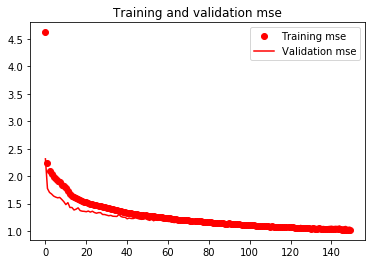

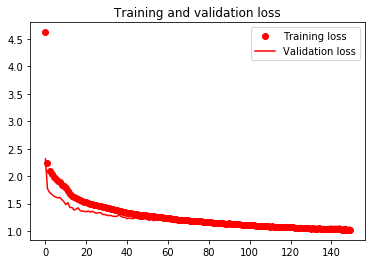

In [51]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse',c='red')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse',c='red')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss',c='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss',c='red')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# test validation
predicted_classes = model.predict([test_X_cell,test_X_drug])

In [ ]:
predicted_value = predicted_classes

In [ ]:
# test validation
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [ ]:
c.to_csv(workdir + '//190516_cdrscan_master_150_100_result.csv')

In [ ]:
c

In [ ]:
predicted_value.shape

In [ ]:
# scatter plot as test validation
plt.scatter(test_label_array,predicted_value,c='red')
plt.xlabel('test_IC50_value')
plt.ylabel('predicted_IC50_value')
plt.savefig(workdir + '//190516_cdrscan_master_150_100_result_test_scatterplot.png')

In [ ]:
# calculate RMSE

rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

In [ ]:
# R-squared value

from sklearn.metrics import r2_score
r2_value = r2_score(b, a) 
print(r2_value)